# Workbook
A pile of code for development

In [1]:
# Base
import itertools
from glob import glob
from tqdm import tqdm
import math
import textgrid
import random
import matplotlib.pyplot as plt

# ML
import torch
import torch.nn.functional as F
from torch.utils.data import DistributedSampler, DataLoader
from torch.utils.tensorboard import SummaryWriter
from IPython.display import Audio, display
from vocos import Vocos
import pyworld as pw

# Local
from utils.misc import plot_specgram, plot_waveform
from utils.dataset import prepare_textgrid_alignments
from supervoice.audio import spectogram, load_mono_audio, melscale_fbanks
from supervoice.model_audio import AudioPredictor
from supervoice.tokenizer import Tokenizer
from supervoice.tensors import drop_using_mask
from supervoice.config import config

In [2]:
device = "cpu"

# Vocoder
vocoder = torch.hub.load(repo_or_dir='ex3ndr/supervoice-vocoder', model='bigvsan')
vocoder = vocoder.to(device)
def do_vocoder(src):
    with torch.no_grad():
        return vocoder.generate(src)

# GPT
# phonemizator = torch.hub.load(repo_or_dir='ex3ndr/supervoice-gpt', model='phonemizer')

# Tokenizer
tokenizer = Tokenizer(config)
phoneme_duration = config.audio.hop_size / config.audio.sample_rate

# Load index
files = glob("datasets/eval-aligned/**/*.TextGrid")
files = [f[len("datasets/eval-aligned/"):-len(".TextGrid")] for f in files]

# Load textgrids
tg = [textgrid.TextGrid.fromFile("datasets/eval-aligned/" + f + ".TextGrid") for f in files]

# Load audio
styles = ["datasets/eval-prepared/" + f + ".style.pt" for f in files]
files = ["datasets/eval-prepared/" + f + ".wav" for f in files]

Using cache found in /home/steve/.cache/torch/hub/ex3ndr_supervoice-vocoder_master


In [11]:
def extract_tokens(src, style, audio, condition = False):
    aligned_phonemes = prepare_textgrid_alignments(src, style, audio.shape[1], phoneme_duration, not condition)
    phonemes = []
    styles = []
    for t in aligned_phonemes:
        for i in range(t[1]):
            phonemes.append(t[0])
            styles.append(t[2])
    tokens = tokenizer(phonemes)
    return tokens, phonemes, torch.tensor(styles)

def audio_denormalize(src):
    return (src * config.audio.norm_std) + config.audio.norm_mean

def audio_normalize(src):
    return (src - config.audio.norm_mean) / config.audio.norm_std

def do_spectogram(src):
    return spectogram(src, config.audio.n_fft, config.audio.n_mels, config.audio.hop_size, config.audio.win_size, config.audio.mel_norm, config.audio.mel_scale, config.audio.sample_rate)

def empty_tokens(size):
    return torch.zeros((size)).long().to(device)

def empty_mask(size):
    return torch.ones((size)).bool().to(device)

def plot_debug(waveform, spec):

    # Convert to CPU
    waveform = waveform.cpu()
    spec = spec.cpu()

    # Display audio
    display(Audio(data=waveform, rate=config.audio.sample_rate))

    # Pitch detector
    f0, t0 = pw.dio(waveform.squeeze(0).numpy().astype('double'), config.audio.sample_rate, frame_period=(1000 * config.audio.hop_size)/config.audio.sample_rate)
    # f0 = 2595 * torch.log10(1 + torch.tensor(f0) / 700)
    f0 = (f0 - 0) / (24000 - 0) * (100 - 1)

    # Plot
    _, axis = plt.subplots(1, 1, figsize=(20, 10))
    axis.imshow(spec, cmap="viridis", vmin=-10, vmax=0, origin="lower", aspect="auto")
    axis.plot(f0, color="white")
    # axis.set_title(title)
    plt.tight_layout()

### Load Model

In [12]:
model = AudioPredictor(config)
model = model.to(device)
checkpoint = torch.load(f'./output/audio_pitch.pt', map_location="cpu")
model.load_state_dict(checkpoint['model'])
model.eval()
print("Predictor at ", checkpoint['step'])

# def synthesize(tokens = None, styles = None, condition_audio = None, condition_tokens = None, condition_style = None):
    
    

Predictor at  63000


### Load audio with phonemes
This loads sample audio that we would be able to use to compare with synthesized one

tensor([  0,   1,   1,   1,   1,   1,  37,  37,  37,  37,  37, 182, 182, 182,
        182, 182, 187, 187, 187, 187, 187, 187, 187, 190, 190, 190, 190, 190,
        190,  28,  28,  28,  28,  28,  28,  28,   1,   1,   1,  48,  48,  48,
         48, 185, 185, 185, 185, 185, 185, 176, 176, 176, 176, 176, 176, 176,
         50,  50,  50,  50,  50,  50,  50, 167, 167, 167, 167, 167, 167, 167,
        167, 167, 167, 167, 167,  90,  90,  90,  90,  90,  90,  90,  90,   1,
          1,   1,   1,   1, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158,
        148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
        148, 148,  71,  71,  71,  71,  71,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1, 181, 181, 181, 181, 181, 181, 178,
        178, 178, 178,  39,  39,  39,  39,  39,  39,  39,  39,  39,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1, 157, 157, 157, 157, 157, 157, 157, 157,  80,  80,  

Source audio re-created


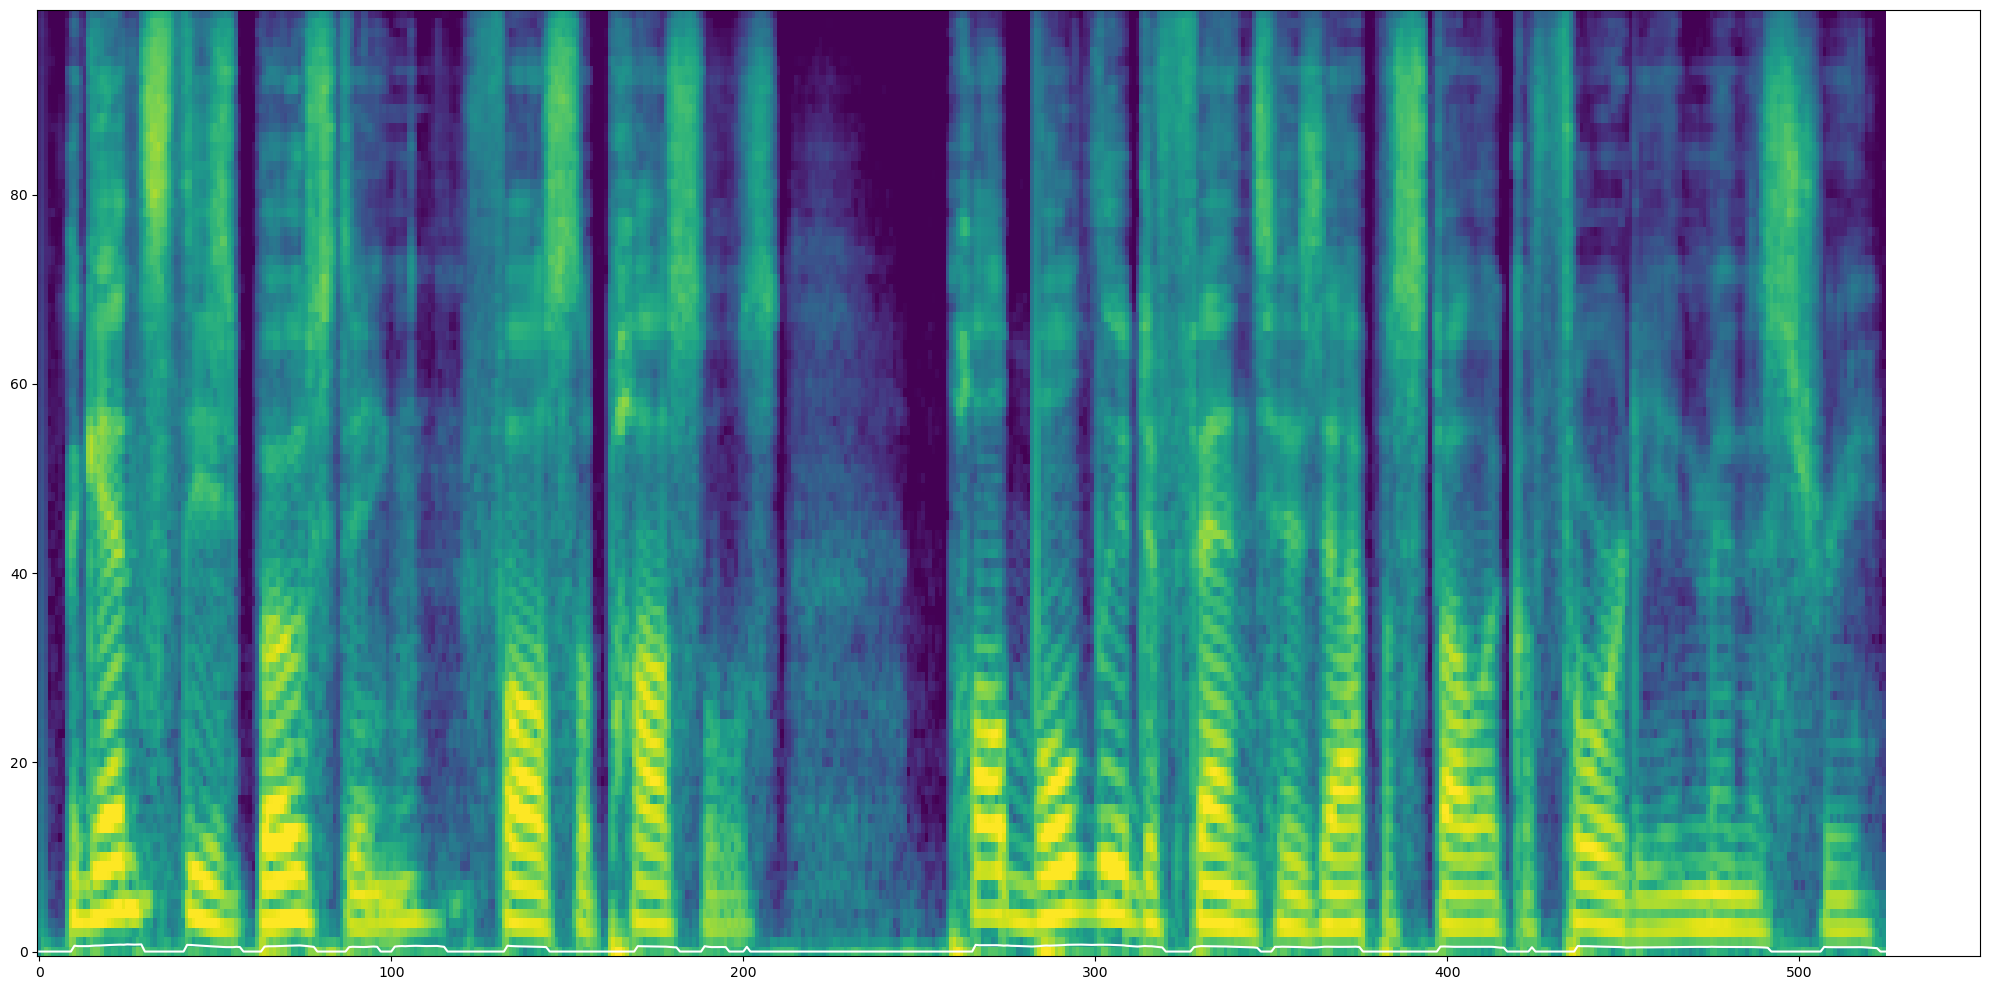

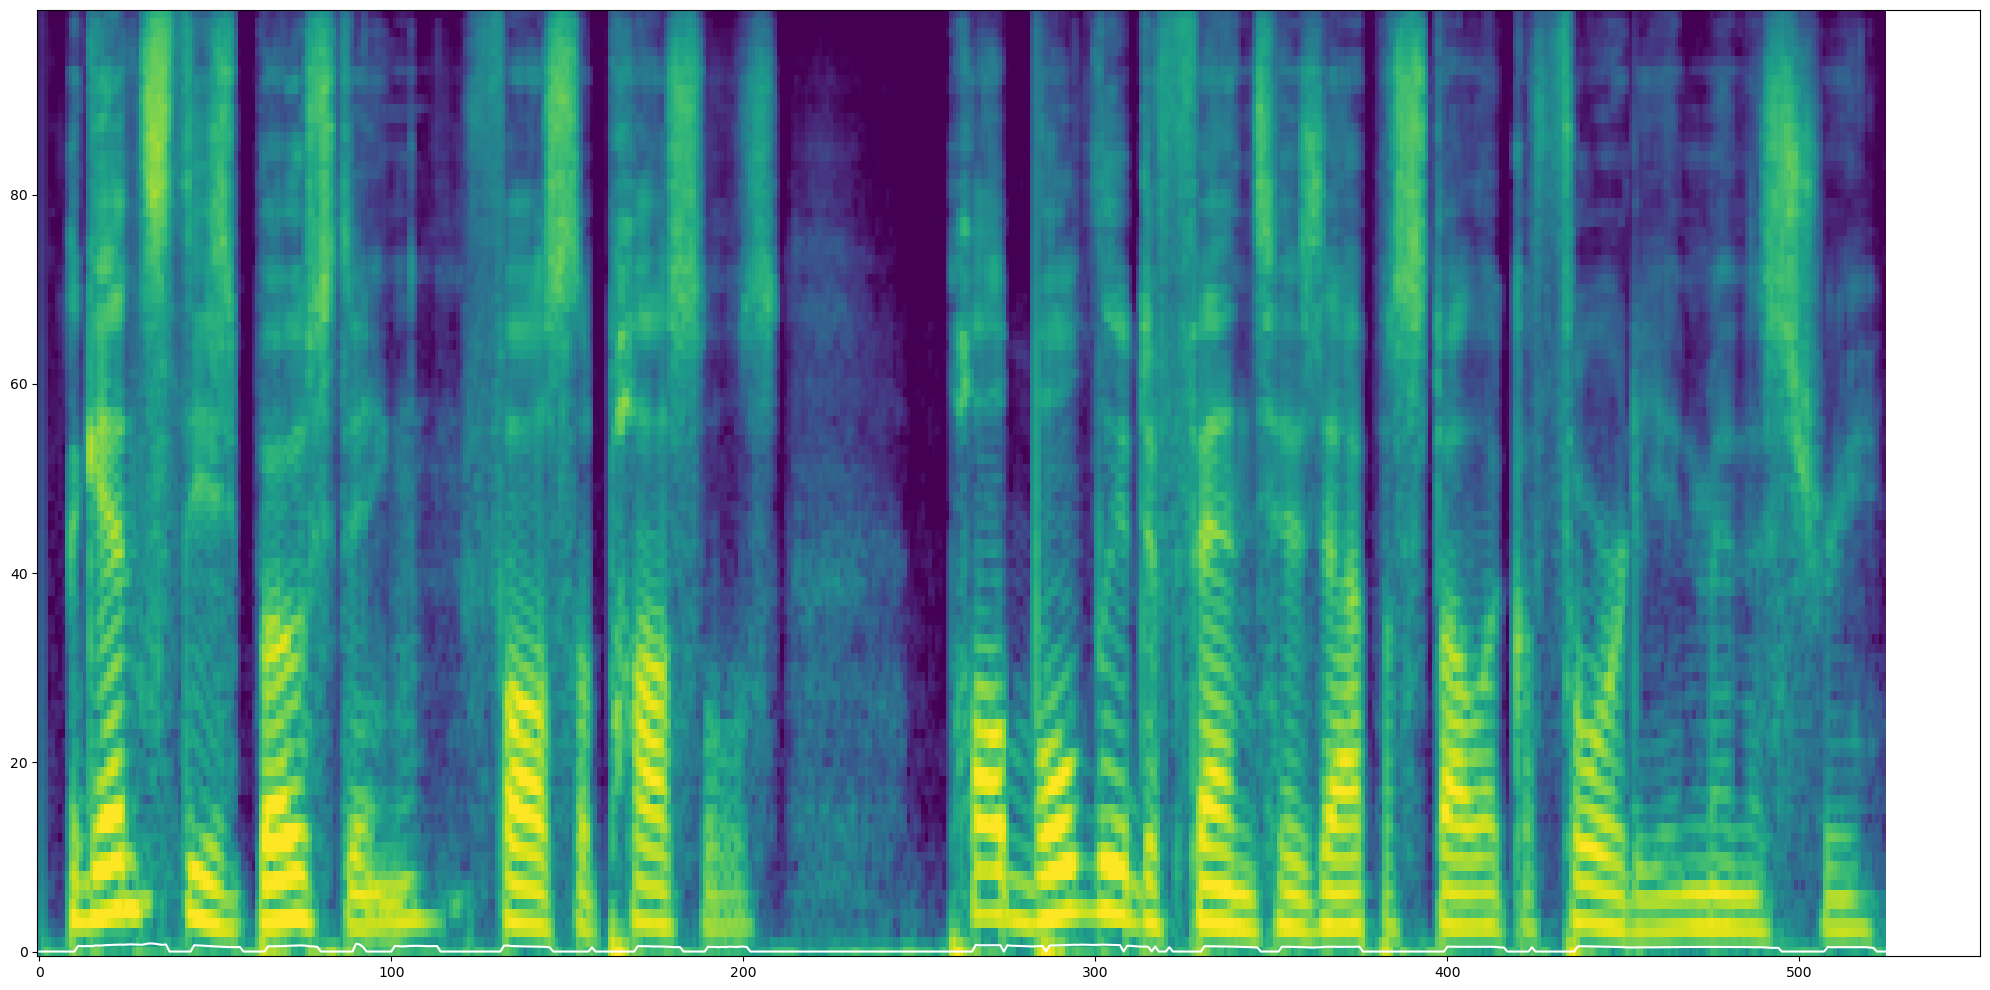

In [13]:
# Load audio
index = 300
waveform = load_mono_audio(files[index], sample_rate = config.audio.sample_rate)
style = torch.load(styles[index])
spec = do_spectogram(waveform)
spec = spec.to(device)
tokens, _, token_styles = extract_tokens(tg[index], style, spec)
tokens = tokens.to(device)
token_styles = token_styles.to(device)
spec = spec[:, :len(tokens)]
print(token_styles)
print(style)

print("Source audio")
plot_debug(waveform, spec)
print("Source audio re-created")
plot_debug(do_vocoder(spec), spec)

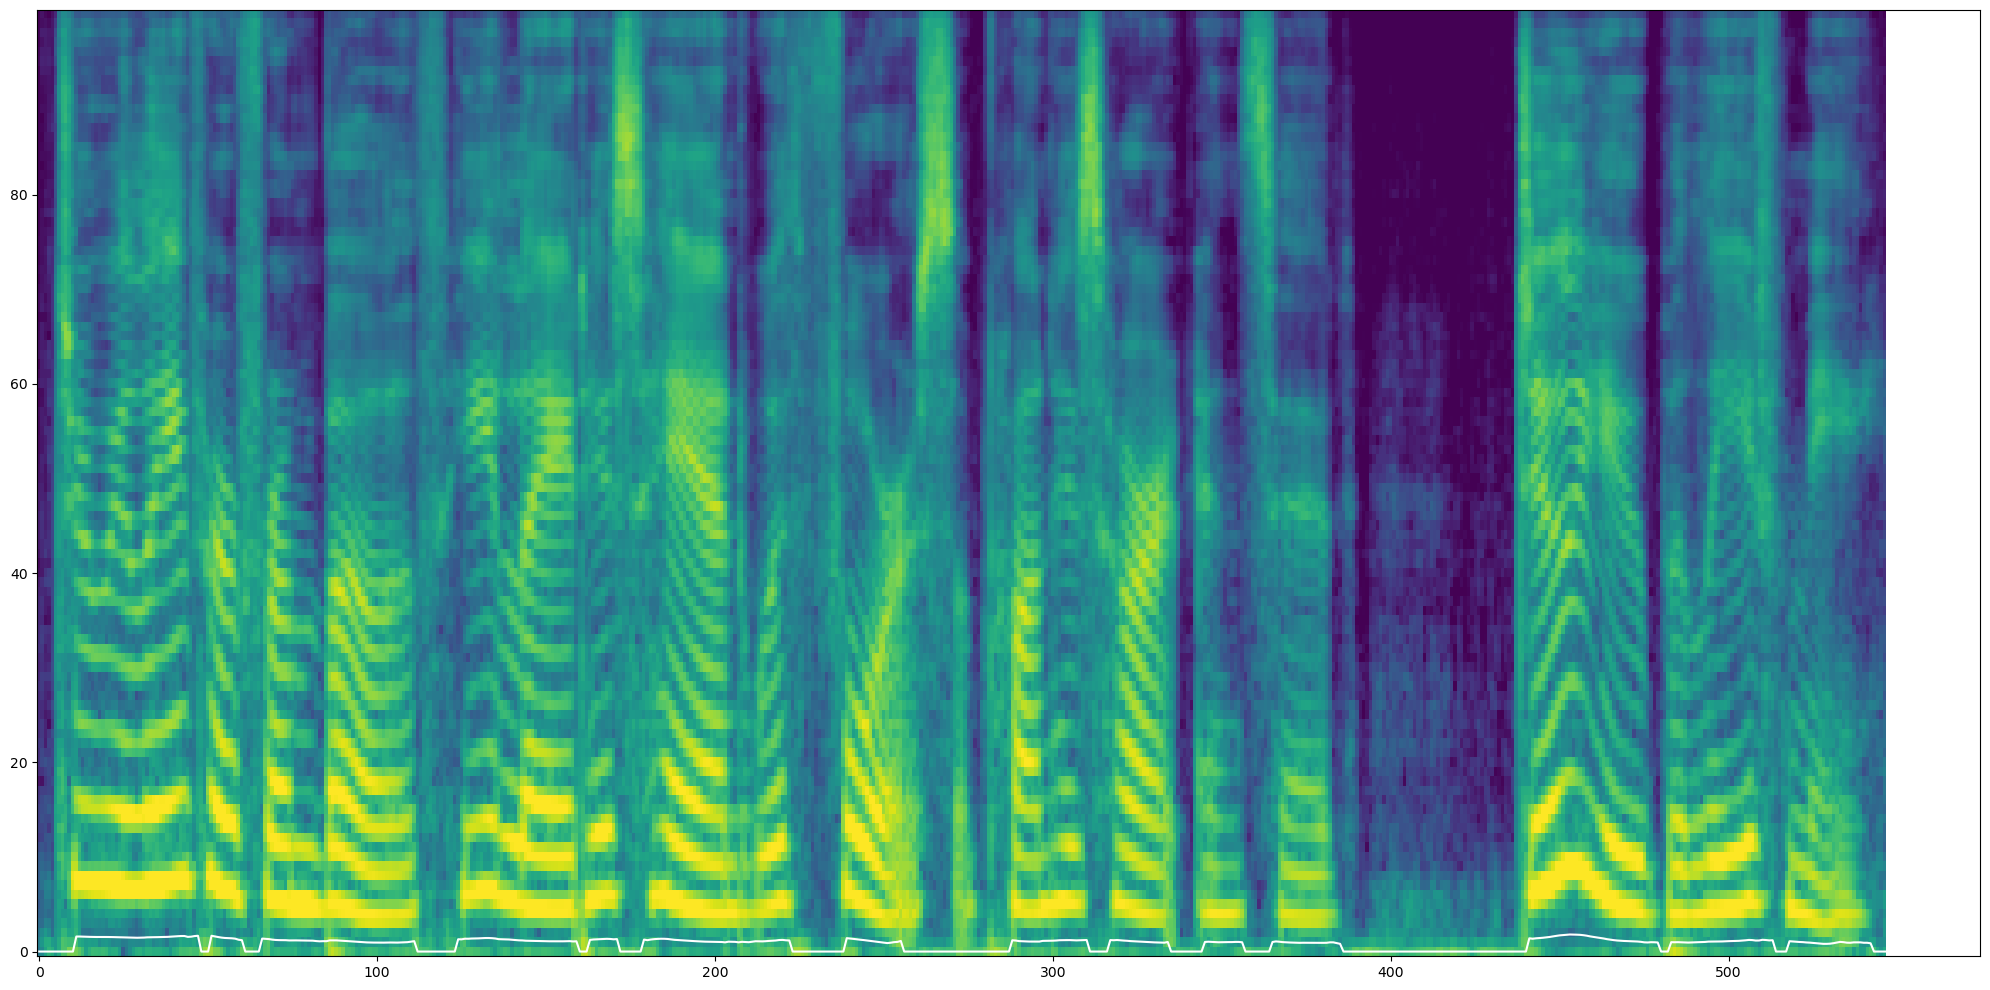

In [6]:
# Load conditioning audio
cond_index = 2107
cond_waveform = load_mono_audio(files[cond_index], sample_rate = config.audio.sample_rate)
cond_style = torch.load(styles[cond_index])
cond_spec = do_spectogram(cond_waveform)
cond_tokens, _, cond_token_styles = extract_tokens(tg[cond_index], cond_style, cond_spec, True)
cond_spec = cond_spec.to(device)
cond_tokens = cond_tokens.to(device)
cond_token_styles = cond_token_styles.to(device)
cond_spec = cond_spec[:, :len(cond_tokens)]
assert len(cond_tokens) == cond_spec.shape[1]

plot_debug(cond_waveform, cond_spec)

# Synthesize voice from phonemes
This synthesizes random voice from existing phonemes (taken from another file)

In [7]:
with torch.no_grad():

    # Params
    s_steps = 8
    s_tokens = tokens
    s_tokens_style = token_styles
    s_audio = torch.zeros((len(tokens), config.audio.n_mels)).to(device)
    s_mask = empty_mask(len(tokens))
    print(s_tokens_style)

    # Synthesize
    sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = s_steps, alpha = 0.5)
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source of phonemes")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Synthesized with phonemes provided")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

tensor([  0,   1,   1,   1,   1,   1,  37,  37,  37,  37,  37, 182, 182, 182,
        182, 182, 187, 187, 187, 187, 187, 187, 187, 190, 190, 190, 190, 190,
        190,  28,  28,  28,  28,  28,  28,  28,   1,   1,   1,  48,  48,  48,
         48, 185, 185, 185, 185, 185, 185, 176, 176, 176, 176, 176, 176, 176,
         50,  50,  50,  50,  50,  50,  50, 167, 167, 167, 167, 167, 167, 167,
        167, 167, 167, 167, 167,  90,  90,  90,  90,  90,  90,  90,  90,   1,
          1,   1,   1,   1, 158, 158, 158, 158, 158, 158, 158, 158, 158, 158,
        148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148, 148,
        148, 148,  71,  71,  71,  71,  71,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1, 181, 181, 181, 181, 181, 181, 178,
        178, 178, 178,  39,  39,  39,  39,  39,  39,  39,  39,  39,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1, 157, 157, 157, 157, 157, 157, 157, 157,  80,  80,  

Synthesized with phonemes provided


In [8]:
with torch.no_grad():

    # Params
    s_steps = 8
    s_tokens = tokens
    s_tokens_style = torch.zeros(len(tokens)).long().to(device)
    s_audio = torch.zeros((len(tokens), config.audio.n_mels)).to(device)
    s_mask = empty_mask(len(tokens))

    # Synthesize
    sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = s_steps, alpha = 0.5)
    sample = audio_denormalize(sample)
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source of phonemes")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Synthesized with phonemes provided without styles")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

Source of phonemes


Synthesized with phonemes provided without styles


### Restore segment
Cut part of the audio and re-generate segment

Source


Restored segment with tokens provided


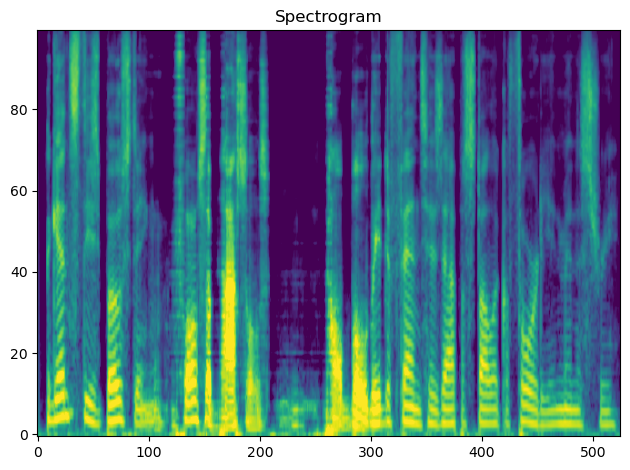

In [9]:
with torch.no_grad():

    # Params
    s_steps = 4
    s_tokens = tokens
    s_tokens_style = token_styles + 1
    s_audio = audio_normalize(spec.transpose(1,0))

    # Mask
    seq_len = len(tokens)
    s_mask = torch.zeros((seq_len)).bool().to(device)
    s_mask[math.floor(seq_len * 0.2): math.floor(seq_len * 0.6)] = True
    s_audio = drop_using_mask(s_audio, 0, s_mask)

    # Restore audio
    sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = s_steps)
    sample = audio_denormalize(sample) * 1.2
    trajectory = audio_denormalize(trajectory)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Restored segment with tokens provided")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
plot_specgram(sample.transpose(1,0).cpu())
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

### Conditioned TTS

In [10]:
def conditioned_tts(tokens, steps = 8, alpha = 0.5):
    with torch.no_grad():

        # Create tokens
        s_audio = audio_normalize(torch.cat([cond_spec.transpose(1,0), torch.zeros(len(tokens) + 2, config.audio.n_mels, device=device)]))
        s_tokens = torch.cat([
            torch.tensor([tokenizer.begin_token_id], device=device), 
            cond_tokens[1:], 
            tokens, 
            torch.tensor([tokenizer.silence_token_id, tokenizer.end_token_id], device=device)])
        s_tokens_style = torch.cat([
            torch.tensor([0], device=device), 
            cond_token_styles[1:] + 1, 
            token_styles + 1, 
            torch.tensor([0, 0], device=device)])

        # Create a mask
        s_mask = torch.zeros((len(cond_tokens) + len(tokens) + 2)).bool().to(device)
        s_mask[len(cond_tokens):len(s_mask)] = True

        # Restore audio
        sample, trajectory = model.sample(tokens = s_tokens, tokens_style = s_tokens_style, audio = s_audio, mask = s_mask, steps = s_steps, alpha = alpha)
        sample = audio_denormalize(sample)
        trajectory = audio_denormalize(trajectory)
        sample = sample[len(cond_tokens):-2] * 1.2
        trajectory = trajectory[:,len(cond_tokens):]
        
        return sample, trajectory

sample, trajectory = conditioned_tts(tokens)

# Resynth
resynth = do_vocoder(sample.transpose(1,0).unsqueeze(0).to(device)).detach().cpu().squeeze(0)

# Display audio
print("Source audio of phonemes and durations")
display(Audio(data=waveform, rate=config.audio.sample_rate))
print("Synthesized voice")
display(Audio(data=resynth, rate=config.audio.sample_rate))

# Display trajectory
# for i in reversed(range(len(trajectory))):
#     plot_specgram(trajectory[i].transpose(1,0).cpu())    

Source audio of phonemes and durations


Synthesized voice
